# Add alpha factors

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [147]:
import warnings
warnings.filterwarnings('ignore')

In [148]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# from pyfinance.ols import PandasRollingOLS

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from talib import RSI, BBANDS, MACD, NATR, ATR, PPO

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load MERVAL OHLCV data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

Set data store location:

In [150]:
DATA_STORE = './data/assets.h5'

In [151]:
YEAR = 12

In [152]:
START = 2010
END = 2024

In [153]:
with pd.HDFStore(DATA_STORE, 'r') as store:
    prices = (store['merval/prices']
              .loc[idx[str(START):str(END), :], :]
              .filter(like='adj_')
              .dropna()
              .swaplevel()
              .rename(columns=lambda x: x.replace('adj_', ''))
              .join(store['merval/stocks']
                    .loc[:, ['sector']])
              .dropna())

In [154]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 186798 entries, ('ALUA.BA', Timestamp('2010-01-04 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    186798 non-null  float64
 1   high    186798 non-null  float64
 2   low     186798 non-null  float64
 3   close   186798 non-null  float64
 4   volume  186798 non-null  float64
 5   sector  186798 non-null  object 
dtypes: float64(5), object(1)
memory usage: 9.2+ MB


In [155]:
len(prices.index.unique('ticker'))

58

## Time series

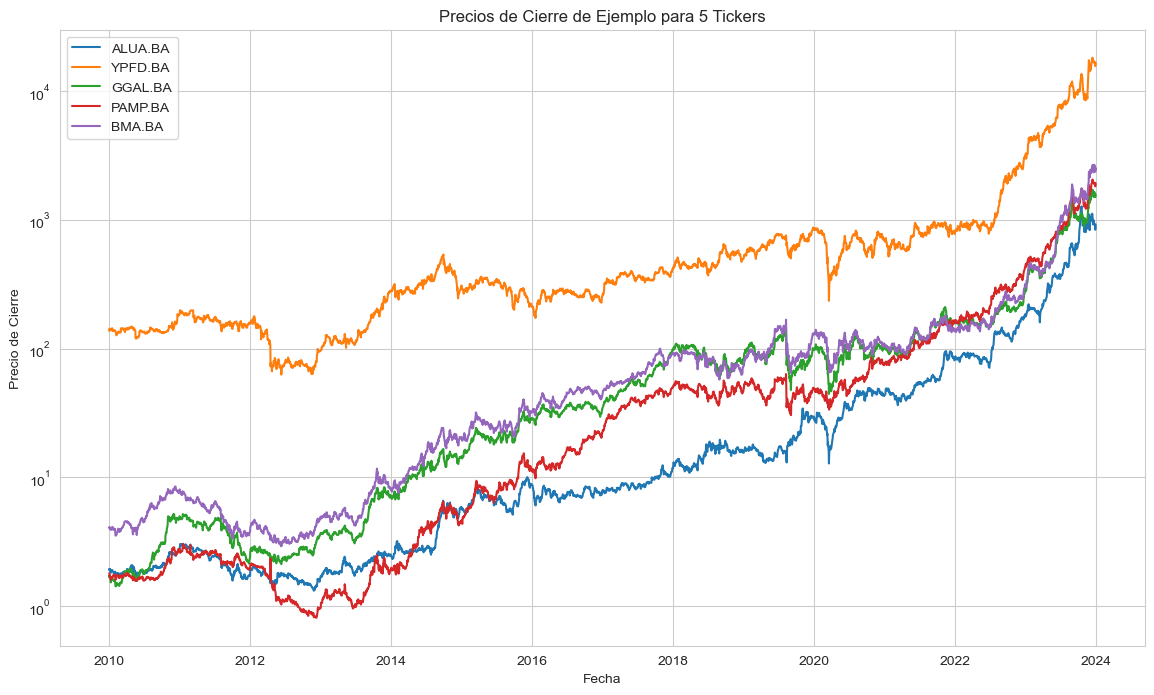

In [156]:
import pandas as pd
import matplotlib.pyplot as plt

# Seleccionamos 5 tickers de ejemplo
tickers = ['ALUA.BA', 'YPFD.BA', 'GGAL.BA', 'PAMP.BA', 'BMA.BA']

# Filtramos el DataFrame para incluir solo estos tickers
df_filtered = prices.loc[tickers]

# Graficamos los precios de cierre de los 5 tickers
plt.figure(figsize=(14, 8))

for ticker in tickers:
    plt.plot(df_filtered.loc[ticker].index, df_filtered.loc[ticker]['close'], label=ticker)
plt.yscale('log')
plt.title('Precios de Cierre de Ejemplo para 5 Tickers')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.grid(True)
plt.show()

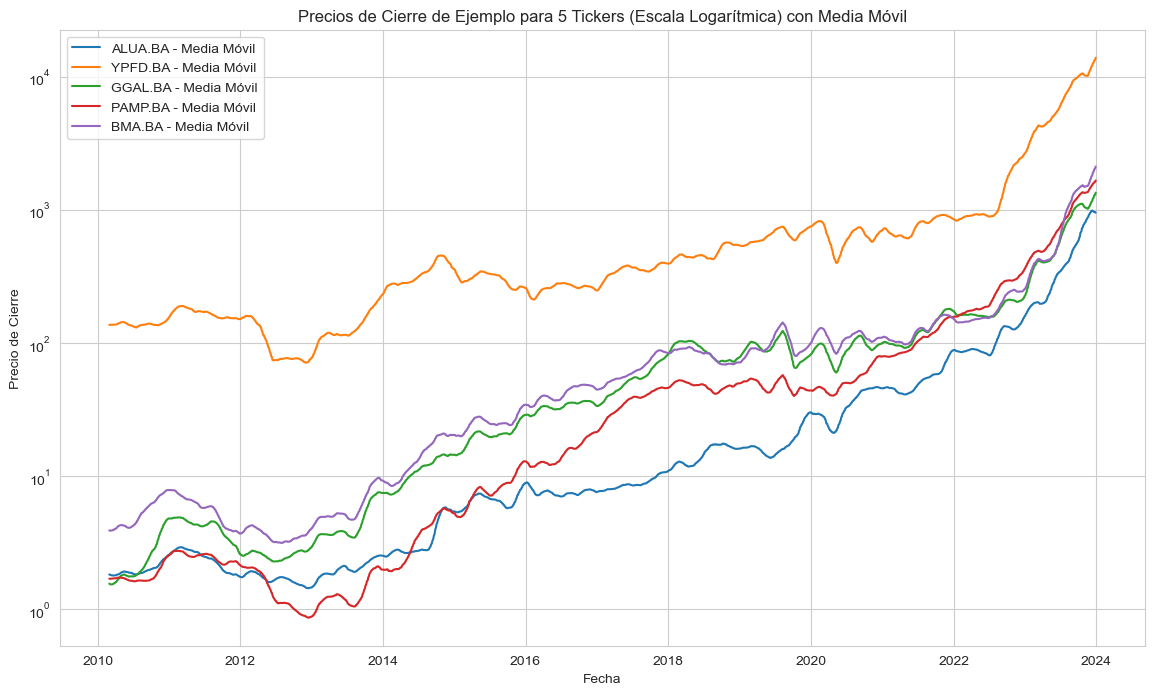

In [219]:

# Parámetro para la media móvil
window_size = 40

# Graficamos los precios de cierre de los 5 tickers en escala logarítmica con media móvil
plt.figure(figsize=(14, 8))

for ticker in tickers:
    # Precio de cierre suavizado (media móvil)
    rolling_mean = df_filtered.loc[ticker]['close'].rolling(window=window_size).mean()
    plt.plot(df_filtered.loc[ticker].index, rolling_mean, label=f'{ticker} - Media Móvil')

plt.title('Precios de Cierre de Ejemplo para 5 Tickers (Escala Logarítmica) con Media Móvil')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [239]:
import requests
from datetime import timedelta, datetime

# Función para obtener los tipos de cambio de dolarhoy.com
def get_exchange_rate_history():
    url = "https://api.argentinadatos.com/v1/cotizaciones/dolares"  # Endpoint hipotético, cambia según el correcto
    response = requests.get(url)
    data = response.json()

    # Filtrar los datos para incluir solo aquellos con casa: "blue"
    exchange_rates = [
        {'date': item['fecha'], 'exchange_rate': item['venta']}
        for item in data
        if item['casa'] == 'blue'
    ]

    # Convertir a DataFrame
    df_exchange_rates = pd.DataFrame(exchange_rates)
    
    # Convertir la columna 'date' a datetime
    df_exchange_rates['date'] = pd.to_datetime(df_exchange_rates['date'], format='%Y-%m-%d')
    
    return df_exchange_rates

exchange_rates = get_exchange_rate_history()

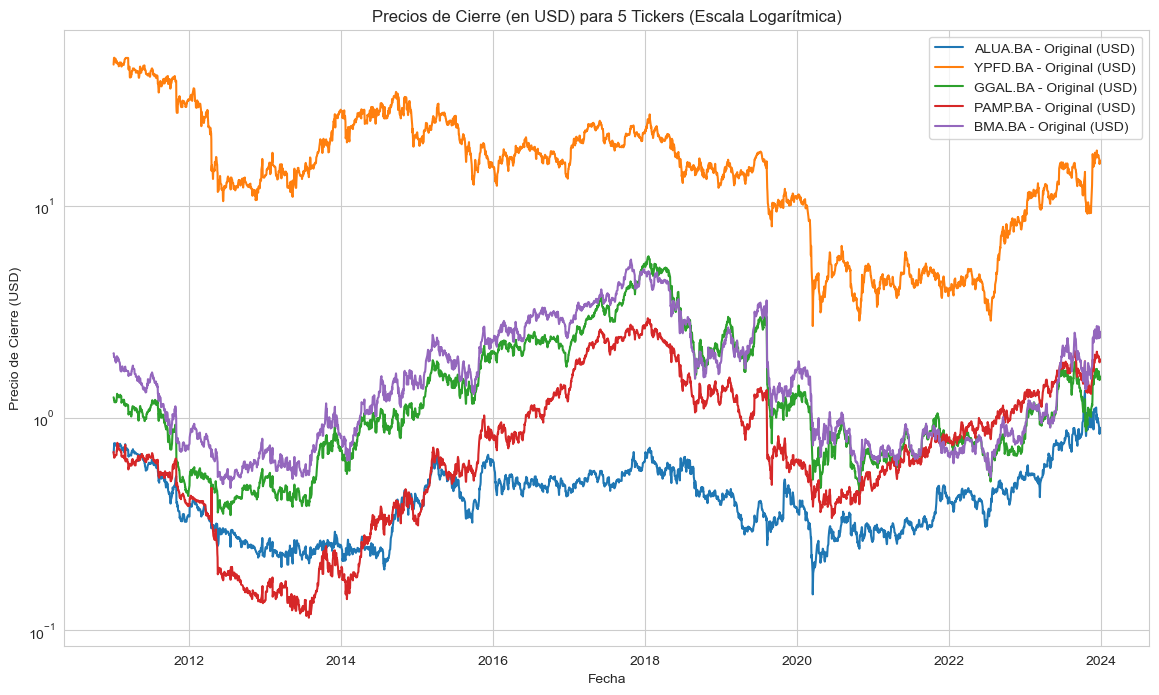

In [240]:
import pandas as pd
import matplotlib.pyplot as plt

tickers = ['ALUA.BA', 'YPFD.BA', 'GGAL.BA', 'PAMP.BA', 'BMA.BA']

# Filtramos el DataFrame para incluir solo estos tickers
df_filtered = prices.loc[tickers]

# Reseteamos el índice para hacer un merge con exchange_rates
df_filtered = df_filtered.reset_index()
exchange_rates = exchange_rates.reset_index()

# Realizamos el merge con el DataFrame de tipos de cambio
df_merged = pd.merge(df_filtered, exchange_rates, left_on='date', right_on='date')

# Calculamos los precios ajustados a dólares
exchange_rates['date'] = pd.to_datetime(exchange_rates['date'])
df_merged['close_usd'] = df_merged['close'] / df_merged['exchange_rate']

# Volvemos a establecer el índice MultiIndex
df_merged.set_index(['ticker', 'date'], inplace=True)

plt.figure(figsize=(14, 8))

for ticker in tickers:
    # Precio de cierre ajustado a dólares
    plt.plot(df_merged.loc[ticker].index, df_merged.loc[ticker]['close_usd'], label=f'{ticker} - Original (USD)')

plt.title('Precios de Cierre (en USD) para 5 Tickers (Escala Logarítmica)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


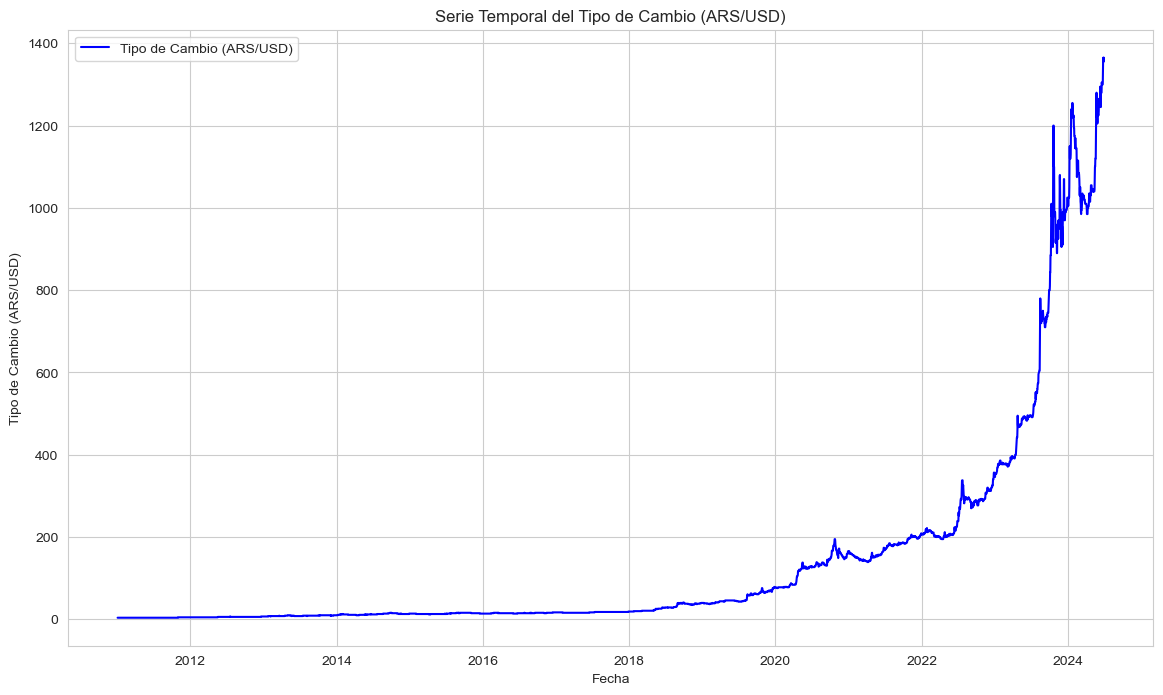

In [241]:
plt.figure(figsize=(14, 8))
plt.plot(exchange_rates['date'], exchange_rates['exchange_rate'], label='Tipo de Cambio (ARS/USD)', color='blue')
plt.title('Serie Temporal del Tipo de Cambio (ARS/USD)')
plt.xlabel('Fecha')
plt.ylabel('Tipo de Cambio (ARS/USD)')
plt.legend()
plt.grid(True)
plt.show()


## Remove stocks with less than ten years of data

In [157]:
min_obs = 10 * 252
nobs = prices.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
prices = prices.drop(to_drop, level='ticker')

In [158]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 176475 entries, ('ALUA.BA', Timestamp('2010-01-04 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    176475 non-null  float64
 1   high    176475 non-null  float64
 2   low     176475 non-null  float64
 3   close   176475 non-null  float64
 4   volume  176475 non-null  float64
 5   sector  176475 non-null  object 
dtypes: float64(5), object(1)
memory usage: 8.7+ MB


In [159]:
len(prices.index.unique('ticker'))

52

## Add some Basic Factors

### Compute the Relative Strength Index

In [160]:
rsi = prices.groupby(level='ticker').close.apply(RSI)
prices['rsi'] = rsi.values

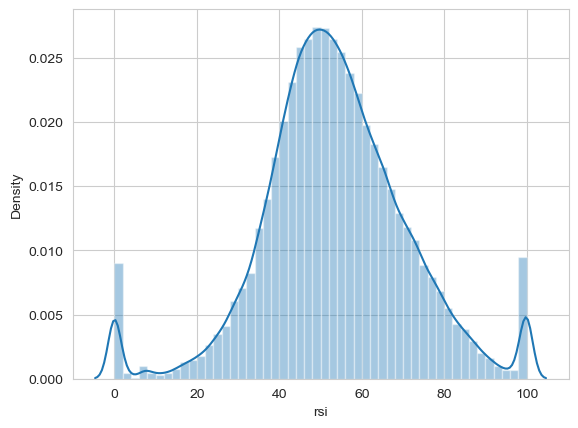

In [161]:
sns.distplot(prices.rsi);

### Compute Bollinger Bands

In [162]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [163]:
bb = prices.groupby(level='ticker').close.apply(compute_bb)

prices['bb_high'] = bb['bb_high'].values
prices['bb_mid'] = bb['bb_mid'].values
prices['bb_low'] = bb['bb_low'].values


In [164]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 176475 entries, ('ALUA.BA', Timestamp('2010-01-04 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   open     176475 non-null  float64
 1   high     176475 non-null  float64
 2   low      176475 non-null  float64
 3   close    176475 non-null  float64
 4   volume   176475 non-null  float64
 5   sector   176475 non-null  object 
 6   rsi      175747 non-null  float64
 7   bb_high  175487 non-null  float64
 8   bb_mid   175487 non-null  float64
 9   bb_low   175487 non-null  float64
dtypes: float64(9), object(1)
memory usage: 14.1+ MB


In [165]:
prices.filter(like='bb_').describe()

,bb_high,bb_mid,bb_low
count,175487.000000,175487.000000,175487.000000
mean,2.684007,2.602322,2.520636
std,1.710969,1.682292,1.656246
min,0.045079,0.043175,-0.340159
25%,1.245484,1.188836,1.134891
50%,2.407402,2.321618,2.238885
75%,3.813107,3.711308,3.618602
max,10.016267,9.712113,9.587675


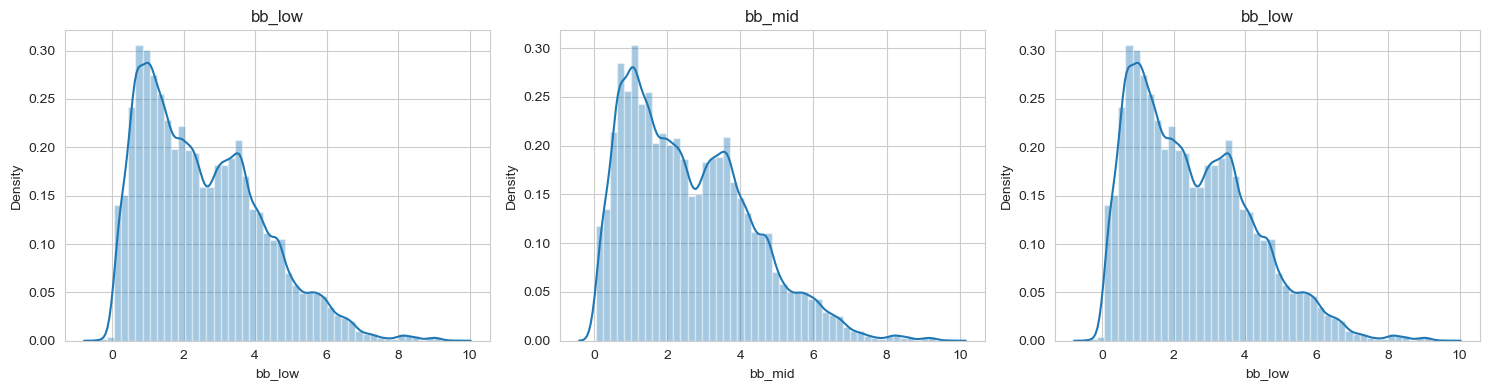

In [166]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [167]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.close))
prices['bb_down'] = np.log1p(prices.close).sub(prices.bb_low)

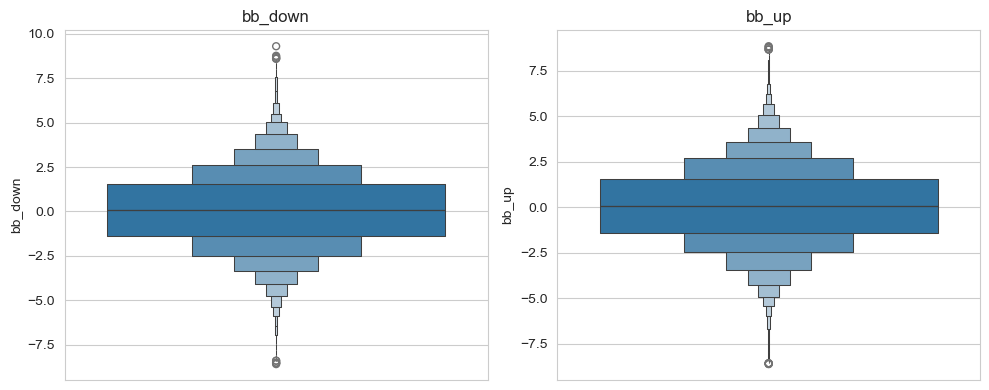

In [168]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

### Compute Average True Range

Helper for indicators with multiple inputs:

In [169]:
by_ticker = prices.groupby('ticker', group_keys=False)

In [170]:
def compute_atr(stock_data):
    atr = ATR(stock_data.high, 
              stock_data.low, 
              stock_data.close, 
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

In [171]:
prices['atr'] = by_ticker.apply(compute_atr)

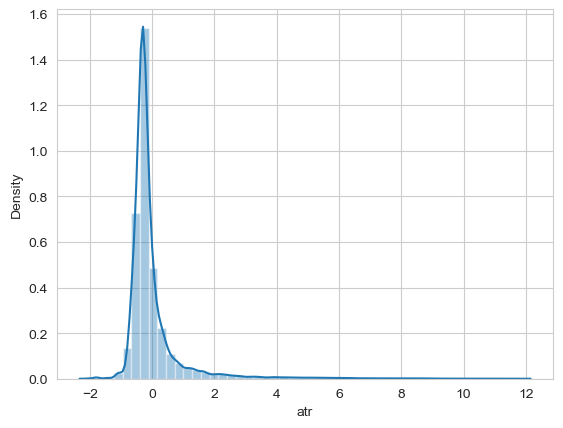

In [172]:
sns.distplot(prices.atr);

In [173]:
prices['natr'] = by_ticker.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close))

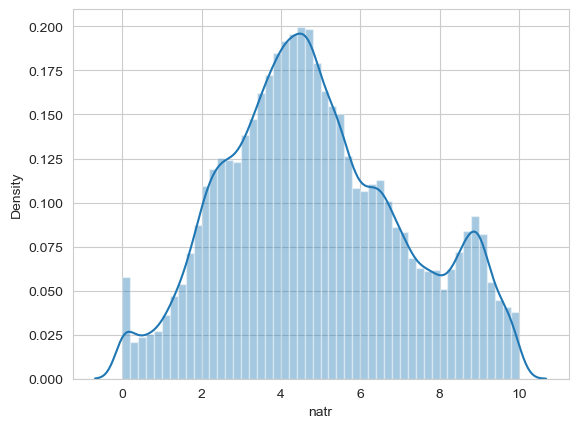

In [174]:
sns.distplot(prices.natr[prices.natr<10]);

### Compute Moving Average Convergence/Divergence

In [175]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices['macd'] = prices.groupby(level='ticker').close.apply(compute_macd).values

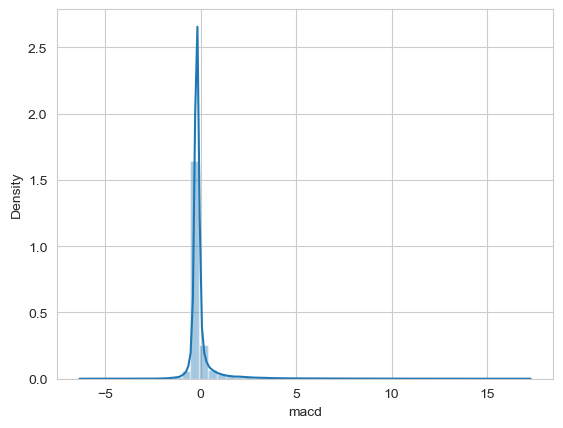

In [176]:
sns.distplot(prices.macd);

### Percentage Price Oscillator

In [177]:
by_ticker = prices.groupby('ticker', group_keys=False)
prices['ppo'] = by_ticker.close.apply(PPO)

## Compute money volume to determine universe

In [178]:
prices['money_volume'] = (prices.loc[:, 'close']
                           .mul(prices.loc[:, 'volume'], axis=0))

prices.money_volume /= 1e6

In [179]:
prices.to_hdf('data.h5', 'merval/prices')

In [180]:
prices = pd.read_hdf('data.h5', 'merval/prices')
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 176475 entries, ('ALUA.BA', Timestamp('2010-01-04 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   open          176475 non-null  float64
 1   high          176475 non-null  float64
 2   low           176475 non-null  float64
 3   close         176475 non-null  float64
 4   volume        176475 non-null  float64
 5   sector        176475 non-null  object 
 6   rsi           175747 non-null  float64
 7   bb_high       175487 non-null  float64
 8   bb_mid        175487 non-null  float64
 9   bb_low        175487 non-null  float64
 10  bb_up         175487 non-null  float64
 11  bb_down       175487 non-null  float64
 12  atr           175747 non-null  float64
 13  natr          175747 non-null  float64
 14  macd          174759 non-null  float64
 15  ppo           175175 non-null  float64
 16  money_vol

## Resample OHLCV prices to monthly frequency

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [181]:
last_cols = [c for c in prices.columns.unique(0) if c not in ['money_volume', 'volume',
                                                              'open', 'high', 'low']]

In [182]:
p = prices.unstack('ticker')
data = (pd.concat([p.money_volume.resample('M').mean().stack('ticker').to_frame('money_volume'),
                   p[last_cols].resample('M').last().stack('ticker')],
                  axis=1)
        .swaplevel()
        .dropna())

In [183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8646 entries, ('ALUA.BA', Timestamp('2010-02-28 00:00:00')) to ('INVJ.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   money_volume  8646 non-null   float64
 1   atr           8646 non-null   float64
 2   bb_down       8646 non-null   float64
 3   bb_high       8646 non-null   float64
 4   bb_low        8646 non-null   float64
 5   bb_mid        8646 non-null   float64
 6   bb_up         8646 non-null   float64
 7   close         8646 non-null   float64
 8   macd          8646 non-null   float64
 9   natr          8646 non-null   float64
 10  ppo           8646 non-null   float64
 11  rsi           8646 non-null   float64
 12  sector        8646 non-null   object 
dtypes: float64(12), object(1)
memory usage: 911.4+ KB


## Create monthly return series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [184]:
outlier_cutoff = 0.01
lags = [1, 3, 6, 12]
returns = []

In [185]:
for lag in lags:
    returns.append(data
                   .close
                   .unstack('ticker')
                   .sort_index()
                   .pct_change(lag)
                   .stack('ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff)))
                   .add(1)
                   .pow(1/lag)
                   .sub(1)
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8594 entries, ('ALUA.BA', Timestamp('2010-03-31 00:00:00')) to ('INVJ.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   8594 non-null   float64
 1   return_3m   8490 non-null   float64
 2   return_6m   8334 non-null   float64
 3   return_12m  8022 non-null   float64
dtypes: float64(4)
memory usage: 297.6+ KB


In [186]:
returns.describe()

,return_1m,return_3m,return_6m,return_12m
count,8594.000000,8490.000000,8334.000000,8022.000000
mean,0.047539,0.038402,0.035911,0.032768
std,0.159561,0.089832,0.063272,0.048093
min,-0.283405,-0.156240,-0.099082,-0.070129
25%,-0.049683,-0.020182,-0.006781,0.000000
50%,0.015036,0.023129,0.027642,0.029145
75%,0.117647,0.087463,0.074605,0.062351
max,0.642434,0.329927,0.222402,0.170342


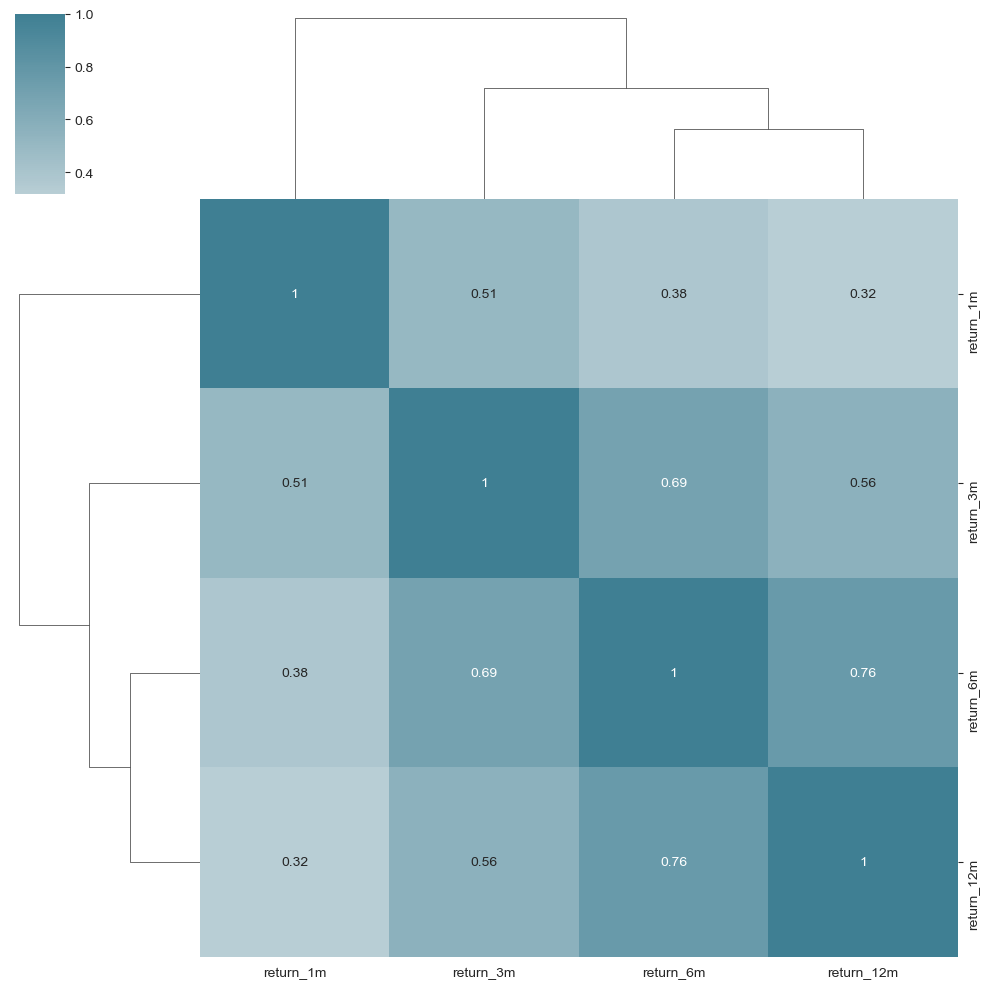

In [187]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [188]:
data = data.join(returns).drop('close', axis=1).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8022 entries, ('ALUA.BA', Timestamp('2011-02-28 00:00:00')) to ('INVJ.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   money_volume  8022 non-null   float64
 1   atr           8022 non-null   float64
 2   bb_down       8022 non-null   float64
 3   bb_high       8022 non-null   float64
 4   bb_low        8022 non-null   float64
 5   bb_mid        8022 non-null   float64
 6   bb_up         8022 non-null   float64
 7   macd          8022 non-null   float64
 8   natr          8022 non-null   float64
 9   ppo           8022 non-null   float64
 10  rsi           8022 non-null   float64
 11  sector        8022 non-null   object 
 12  return_1m     8022 non-null   float64
 13  return_3m     8022 non-null   float64
 14  return_6m     8022 non-null   float64
 15  return_12m    8022 non-null   float64
dtypes: float64(15), object(1)
mem

In [189]:
min_obs = 5*12
nobs = data.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
data = data.drop(to_drop, level='ticker')

In [190]:
tickers_left = len(data.index.unique('ticker'))
f"the result is {tickers_left} tickers"

'the result is 52 tickers'

## Rolling Factor Betas

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

We can use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [191]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                             'famafrench', 
                             start=START)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172 entries, 2010-01-31 to 2024-04-30
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  172 non-null    float64
 1   SMB     172 non-null    float64
 2   HML     172 non-null    float64
 3   RMW     172 non-null    float64
 4   CMA     172 non-null    float64
dtypes: float64(5)
memory usage: 8.1 KB


In [192]:
factor_data = factor_data.join(data['return_1m']).dropna().sort_index()
factor_data['return_1m'] -= factor_data['Mkt-RF']
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8022 entries, ('ALUA.BA', Timestamp('2011-02-28 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     8022 non-null   float64
 1   SMB        8022 non-null   float64
 2   HML        8022 non-null   float64
 3   RMW        8022 non-null   float64
 4   CMA        8022 non-null   float64
 5   return_1m  8022 non-null   float64
dtypes: float64(6)
memory usage: 405.5+ KB


In [193]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
count,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000
mean,0.010087,-0.000783,-0.000977,0.003178,0.000194,0.036021
std,0.043594,0.026615,0.033503,0.020261,0.021548,0.155483
min,-0.133900,-0.082800,-0.138700,-0.047500,-0.072200,-0.348005
25%,-0.015500,-0.018900,-0.018300,-0.012200,-0.013600,-0.060922
50%,0.012700,-0.000600,-0.003700,0.003000,-0.000800,0.006956
75%,0.034400,0.015700,0.013800,0.015600,0.012400,0.105310
max,0.136500,0.073200,0.127500,0.072000,0.077200,0.737034


In [194]:
T = 60
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .rename(columns={'Mkt-RF': 'beta'})
                .drop('const', axis=1)))

In [195]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,8022.000000
mean,0.045736,-0.372046,0.035991,0.001127,0.130775,-0.097831
std,0.628091,0.847574,0.853345,1.108855,1.350791,1.473790
min,-2.180036,-3.543570,-2.736410,-3.716152,-4.464876,-7.412236
25%,-0.328880,-0.888902,-0.508379,-0.718522,-0.785887,-0.628910
50%,0.065858,-0.303462,0.055901,-0.006690,0.154271,0.000000
75%,0.463379,0.168075,0.577221,0.771476,1.035130,0.274880
max,1.907768,3.299309,3.844550,3.587107,4.463103,6.142814


In [196]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,8022.000000
mean,0.045736,-0.372046,0.035991,0.001127,0.130775,-0.097831
std,0.628091,0.847574,0.853345,1.108855,1.350791,1.473790
min,-2.180036,-3.543570,-2.736410,-3.716152,-4.464876,-7.412236
25%,-0.328880,-0.888902,-0.508379,-0.718522,-0.785887,-0.628910
50%,0.065858,-0.303462,0.055901,-0.006690,0.154271,0.000000
75%,0.463379,0.168075,0.577221,0.771476,1.035130,0.274880
max,1.907768,3.299309,3.844550,3.587107,4.463103,6.142814


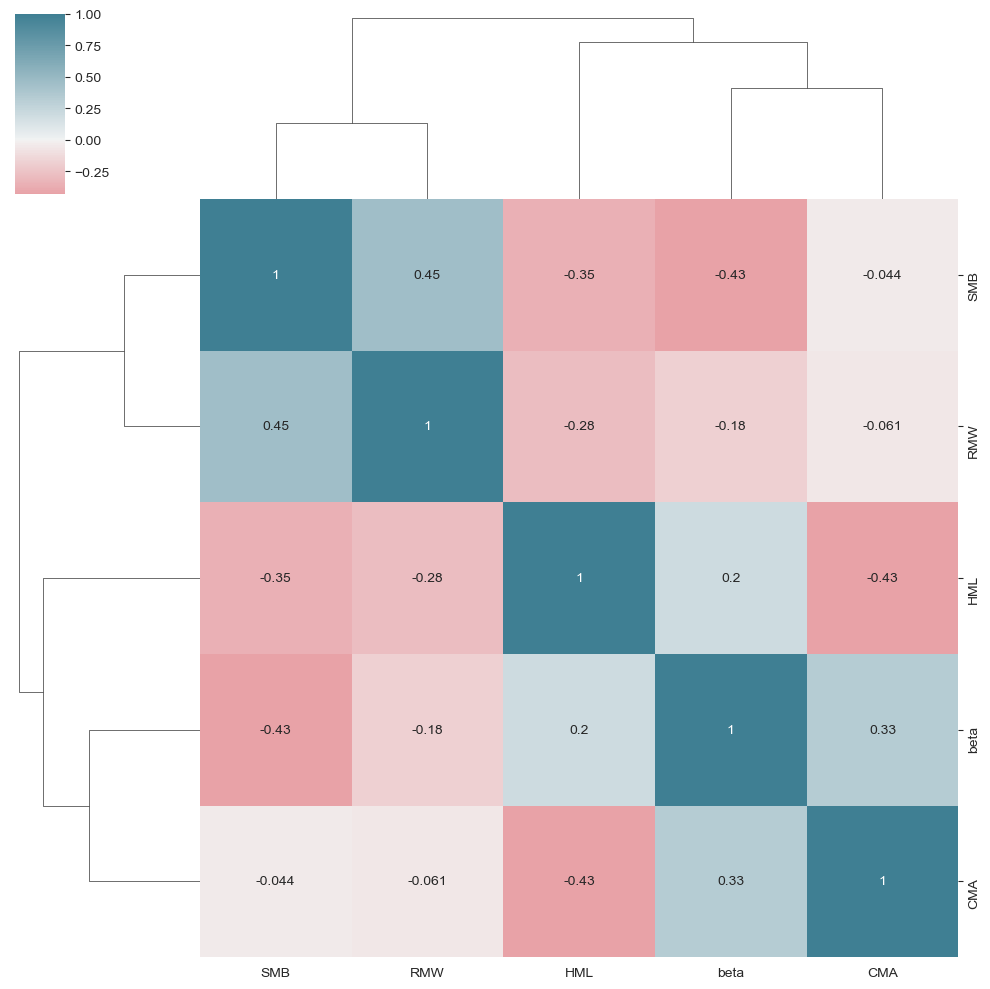

In [197]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [198]:
data = (data
      .join(betas
          .groupby(level='ticker')
          .shift())
     .dropna()
     .sort_index())

In [199]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4902 entries, ('ALUA.BA', Timestamp('2016-02-29 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   money_volume  4902 non-null   float64
 1   atr           4902 non-null   float64
 2   bb_down       4902 non-null   float64
 3   bb_high       4902 non-null   float64
 4   bb_low        4902 non-null   float64
 5   bb_mid        4902 non-null   float64
 6   bb_up         4902 non-null   float64
 7   macd          4902 non-null   float64
 8   natr          4902 non-null   float64
 9   ppo           4902 non-null   float64
 10  rsi           4902 non-null   float64
 11  sector        4902 non-null   object 
 12  return_1m     4902 non-null   float64
 13  return_3m     4902 non-null   float64
 14  return_6m     4902 non-null   float64
 15  return_12m    4902 non-null   float64
 16  beta          4902 non-null  

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [200]:
for lag in [3, 6, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)    

## Date Indicators

In [201]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [202]:
data['target'] = data.groupby(level='ticker')[f'return_1m'].shift(-1)

In [203]:
data = data.dropna()

In [204]:
data.sort_index().info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4850 entries, ('ALUA.BA', Timestamp('2016-02-29 00:00:00')) to ('YPFD.BA', Timestamp('2023-11-30 00:00:00'))
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   money_volume   4850 non-null   float64
 1   atr            4850 non-null   float64
 2   bb_down        4850 non-null   float64
 3   bb_high        4850 non-null   float64
 4   bb_low         4850 non-null   float64
 5   bb_mid         4850 non-null   float64
 6   bb_up          4850 non-null   float64
 7   macd           4850 non-null   float64
 8   natr           4850 non-null   float64
 9   ppo            4850 non-null   float64
 10  rsi            4850 non-null   float64
 11  sector         4850 non-null   object 
 12  return_1m      4850 non-null   float64
 13  return_3m      4850 non-null   float64
 14  return_6m      4850 non-null   float64
 15  return_12m     4850 non-null   float64
 16  beta       

## Sector Breakdown

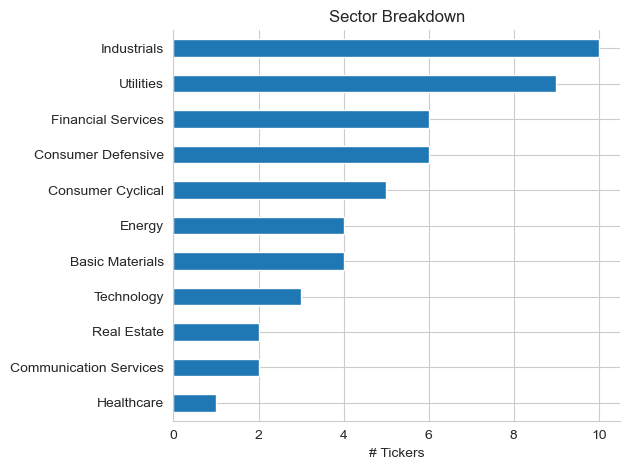

In [205]:
ax = data.reset_index().groupby('sector').ticker.nunique().sort_values().plot.barh(title='Sector Breakdown')
ax.set_ylabel('')
ax.set_xlabel('# Tickers')
sns.despine()
plt.tight_layout();

## Store data

In [206]:
with pd.HDFStore('data.h5') as store:
    store.put('merval/monthly', data)

## Evaluate mutual information

In [207]:
X = data.drop('target', axis=1)
X.sector = pd.factorize(X.sector)[0]

In [208]:
mi = mutual_info_regression(X=X, y=data.target)

In [209]:
mi_reg = pd.Series(mi, index=X.columns)
mi_reg.nlargest(10)

bb_high         0.139385
bb_mid          0.119513
bb_low          0.119111
return_6m       0.082166
ppo             0.073763
year            0.069444
money_volume    0.066752
return_12m      0.061553
momentum_3      0.061227
month           0.061107
dtype: float64

In [210]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [211]:
mi_class = pd.Series(mi, index=X.columns)
mi_class.nlargest(10)

bb_high         0.085063
bb_mid          0.071607
bb_low          0.068614
rsi             0.055023
month           0.039534
macd            0.025122
return_3m       0.021534
return_12m      0.017062
money_volume    0.015021
year            0.014430
dtype: float64

In [212]:
mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

In [213]:
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

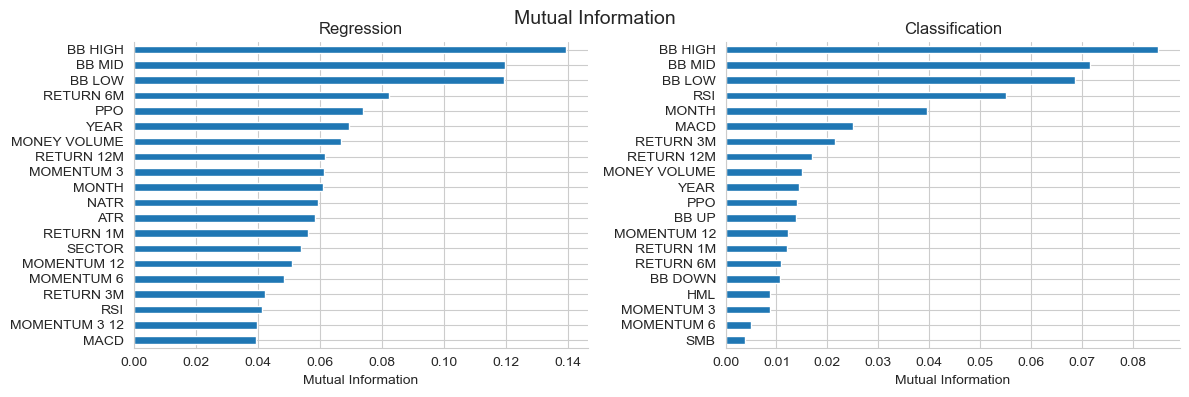

In [214]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

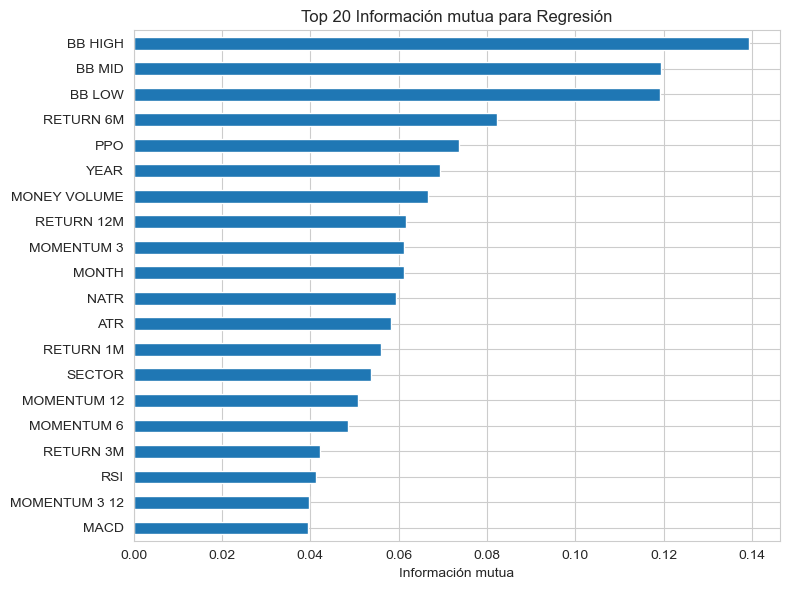

In [253]:
plt.figure(figsize=(8, 6))
mi['Regression'].nlargest(20).sort_values().plot.barh()
plt.title('Top 20 Información mutua para Regresión')
plt.xlabel('Información mutua')
plt.tight_layout()
plt.show()


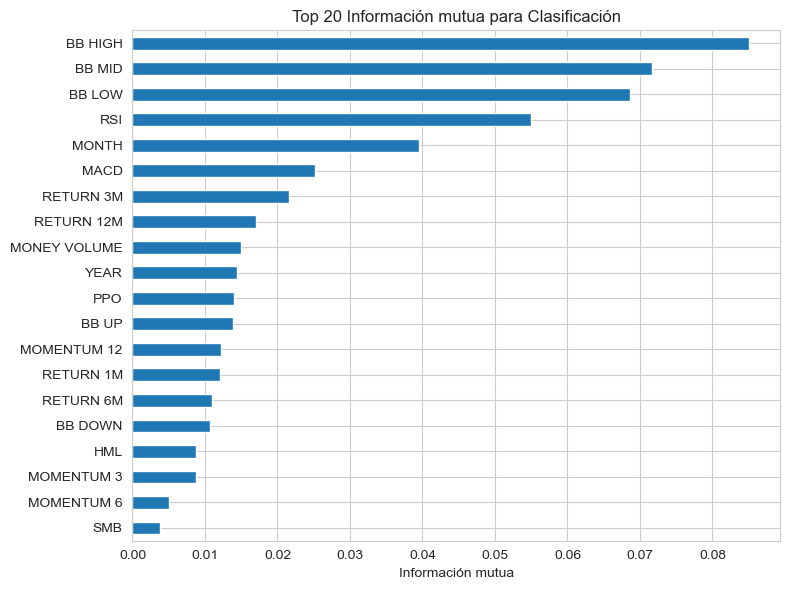

In [254]:
plt.figure(figsize=(8, 6))
mi['Classification'].nlargest(20).sort_values().plot.barh()
plt.title('Top 20 Información mutua para Clasificación')
plt.xlabel('Información mutua')
plt.tight_layout()
plt.show()

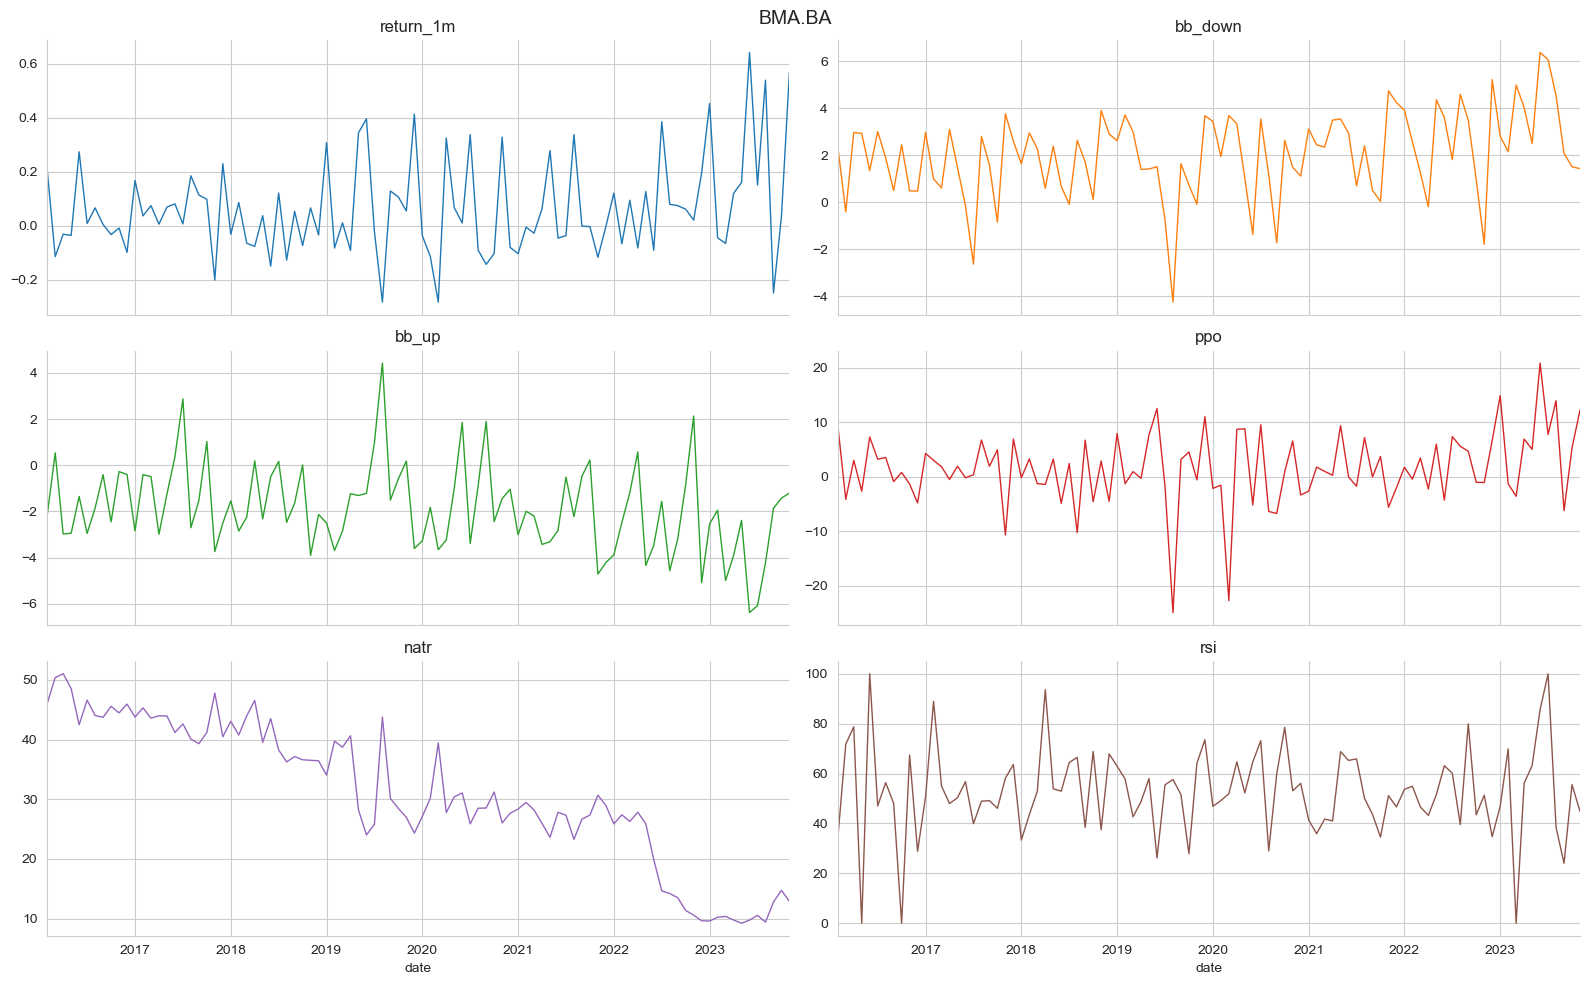

In [215]:
indicators = ['return_1m', 'bb_down', 'bb_up', 'ppo', 'natr', 'rsi']
ticker = np.random.choice(data.index.get_level_values('ticker'))
(data.loc[idx[ticker, :], indicators].reset_index('ticker', drop=True)
 .plot(lw=1, subplots=True, figsize=(16, 10), title=indicators, layout=(3, 2), legend=False))
plt.suptitle(ticker, fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.95)